In [397]:
source('packages.r')
library('pROC')
load('/g/scb2/zeller/karcher/dysb_classif/data/siamcat/profiles_merged_with_metadata.rimage')

In [398]:
metaDataWGS <- metaDataWGS  %>% 
filter(caseControls == "control")
dataMetaAdaptedTruncWideAll <- dataMetaAdaptedTruncWideAll[, colnames(dataMetaAdaptedTruncWideAll) %in% rownames(metaDataWGS)]

In [399]:
tax <- read_tsv('../data/motus2.6_taxonomy_NCBI.tax') %>%
select(mOTUs_ID, Genus, profiled)
tax <- tax %>% 
    mutate(profile_corrected = map_chr(profiled, function(x) {
    str_c(str_split(x, " ")[[1]][2:length(str_split(x, " ")[[1]])], collapse = " ") %>%
        return()
    })) 

# TODO Figure out!
# We loose a few dozen mOTUs (< 0.02% of all mOTUs) cause they're not there in the tax file, not sure why...
tmp <- dataMetaAdaptedTruncWideAll %>% 
mutate(profile_corrected = rownames(.)) %>% 
inner_join(tax %>% select(profile_corrected, Genus), by = 'profile_corrected') %>% 
select(-profile_corrected) %>% 
pivot_longer(-Genus) %>% 
rename(sampleID = name, relAb = value)

tmp2 <- tmp %>% group_by(sampleID, Genus) %>%
summarize(relAb = sum(relAb)) %>%
pivot_wider(id_cols = Genus, names_from = sampleID, values_from = relAb)

tmp3 <- tmp2 %>%
as.data.frame()
rownames(tmp3) <- tmp3$Genus
tmp3$Genus <- NULL
dataMetaAdaptedTruncWideAll <- tmp3   
dataMetaAdaptedTruncWideAll <- dataMetaAdaptedTruncWideAll[, colnames(dataMetaAdaptedTruncWideAll) %in% rownames(metaDataWGS)]
dataMetaAdaptedTruncWideAll  <- dataMetaAdaptedTruncWideAll[, match(rownames(metaDataWGS), colnames(dataMetaAdaptedTruncWideAll))]
#print(colnames(dataMetaAdaptedTruncWideAll) == rownames(metaDataWGS))
#print(dataMetaAdaptedTruncWideAll %>% dim())
#print(metaDataWGS %>% dim())
stopifnot(all(colnames(dataMetaAdaptedTruncWideAll) == rownames(metaDataWGS)))

Parsed with column specification:
cols(
  mOTUs_ID = col_character(),
  Kingdom = col_character(),
  Phylum = col_character(),
  Class = col_character(),
  Order = col_character(),
  Family = col_character(),
  Genus = col_character(),
  Species = col_character(),
  profiled = col_character()
)

`summarise()` regrouping output by 'sampleID' (override with `.groups` argument)


In [400]:
metaDataWGS <- metaDataWGS %>% filter(dataset != 'Backhed_2015_CellHostMicrobe')
dataMetaAdaptedTruncWideAll <- dataMetaAdaptedTruncWideAll[, colnames(dataMetaAdaptedTruncWideAll) %in% rownames(metaDataWGS)]

In [ ]:
# Pairwise distances for PCoA
pwd <- vegdist(t(dataMetaAdaptedTruncWideAll), method = "canberra")
pwd <- as.matrix(pwd)

In [ ]:
pcoa_o <- as.data.frame(pcoa_o)
colnames(pcoa_o) <- c("PCo 1", "PCo 2")
pcoa_o$Sample_ID <- rownames(pcoa_o)

pcoa_o <- pcoa_o %>% 
as_tibble()


Joining, by = "Sample_ID"


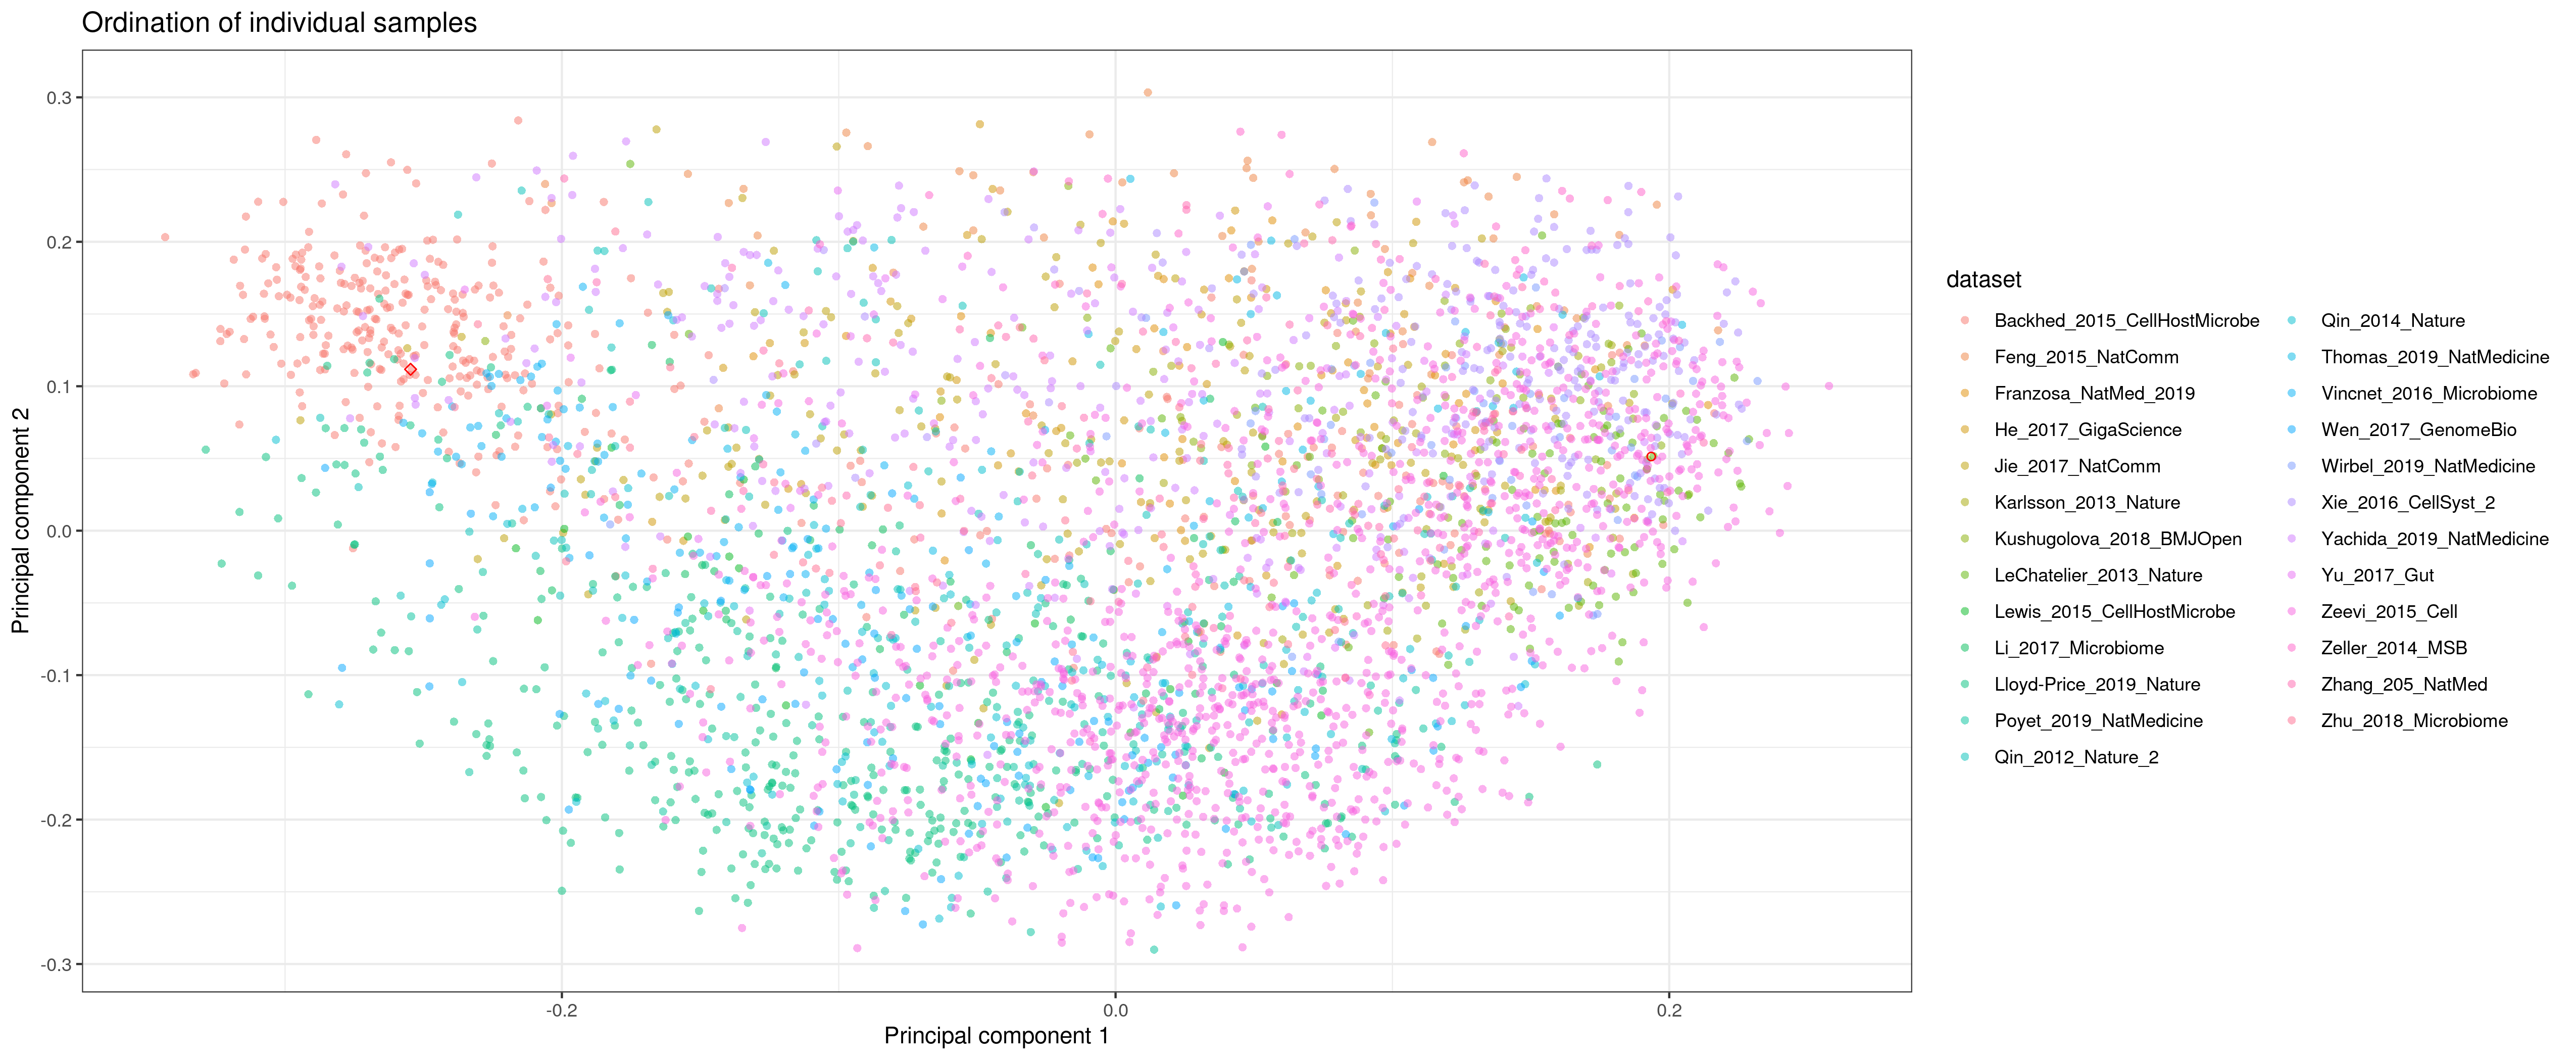

In [356]:
##set.seed(14)
set.seed(14)
pcoa_o$shape <- 16
pcoa_o$shape[sample(1:length(pcoa_o$shape), size = 1)] <- 5
pcoa_o$shape[sample(1:length(pcoa_o$shape), size = 1)] <- 1
pcoa_o$shape <- factor(pcoa_o$shape, levels = c(1, 5, 16))

po <- ggplot()  +
#scale_shape_manual(values = c(1, 5, 16)) +
theme_bw() +
geom_point(data = pcoa_o %>%
           left_join(metaDataWGS %>% mutate(Sample_ID = rownames(.))) %>%
           filter(shape == 16), aes(x = `PCo 1`, y = `PCo 2`, color = dataset, shape = dataset),
           alpha = 0.5, shape = 16) +
geom_point(data = pcoa_o %>%
           filter(shape == 5), aes(x = `PCo 1`, y = `PCo 2`),
           alpha = 1, color = 'red', shape = 5) +
geom_point(data = pcoa_o %>%
           filter(shape == 1), aes(x = `PCo 1`, y = `PCo 2`),
           alpha = 1, color = 'red', shape = 1) +
xlab("Principal component 1") +
ylab("Principal component 2") +
ggtitle("Ordination of individual samples")
print(po)

In [394]:
##set.seed(14)
source('packages.r')
set.seed(14)
pcoa_o$shape <- 16
pcoa_o$shape[sample(1:length(pcoa_o$shape), size = 1)] <- 5
pcoa_o$shape[sample(1:length(pcoa_o$shape), size = 1)] <- 1
pcoa_o$shape <- factor(pcoa_o$shape, levels = c(1, 5, 16))

po <- ggplot()  +
#scale_shape_manual(values = c(1, 5, 16)) +
theme_bw() +
geom_point(data = pcoa_o %>%
           left_join(metaDataWGS %>% mutate(Sample_ID = rownames(.))) %>%
           filter(shape == 16), aes(x = `PCo 1`, y = `PCo 2`, color = dataset, shape = dataset),
           alpha = 0.75) +
# geom_point(data = pcoa_o %>%
#            filter(shape == 5), aes(x = `PCo 1`, y = `PCo 2`),
#            alpha = 1, color = 'red', shape = 5) +
# geom_point(data = pcoa_o %>%
#            filter(shape == 1), aes(x = `PCo 1`, y = `PCo 2`),
#            alpha = 1, color = 'red', shape = 1) +
xlab("Principal component 1") +
ylab("Principal component 2") +
ggtitle("Ordination of individual samples")
#print(po)
po <- scale_color_shape_combined(po, var = pcoa_o %>%
           left_join(metaDataWGS %>% mutate(Sample_ID = rownames(.))) %>%
           filter(shape == 16) %>% pull(dataset) %>% as.factor(), varName = 'dataset', numShapes = 6, colors = c("#7fc97f", "#beaed4", "#fdc086",  "#386cb0", "#f0027f"))

Joining, by = "Sample_ID"
Joining, by = "Sample_ID"


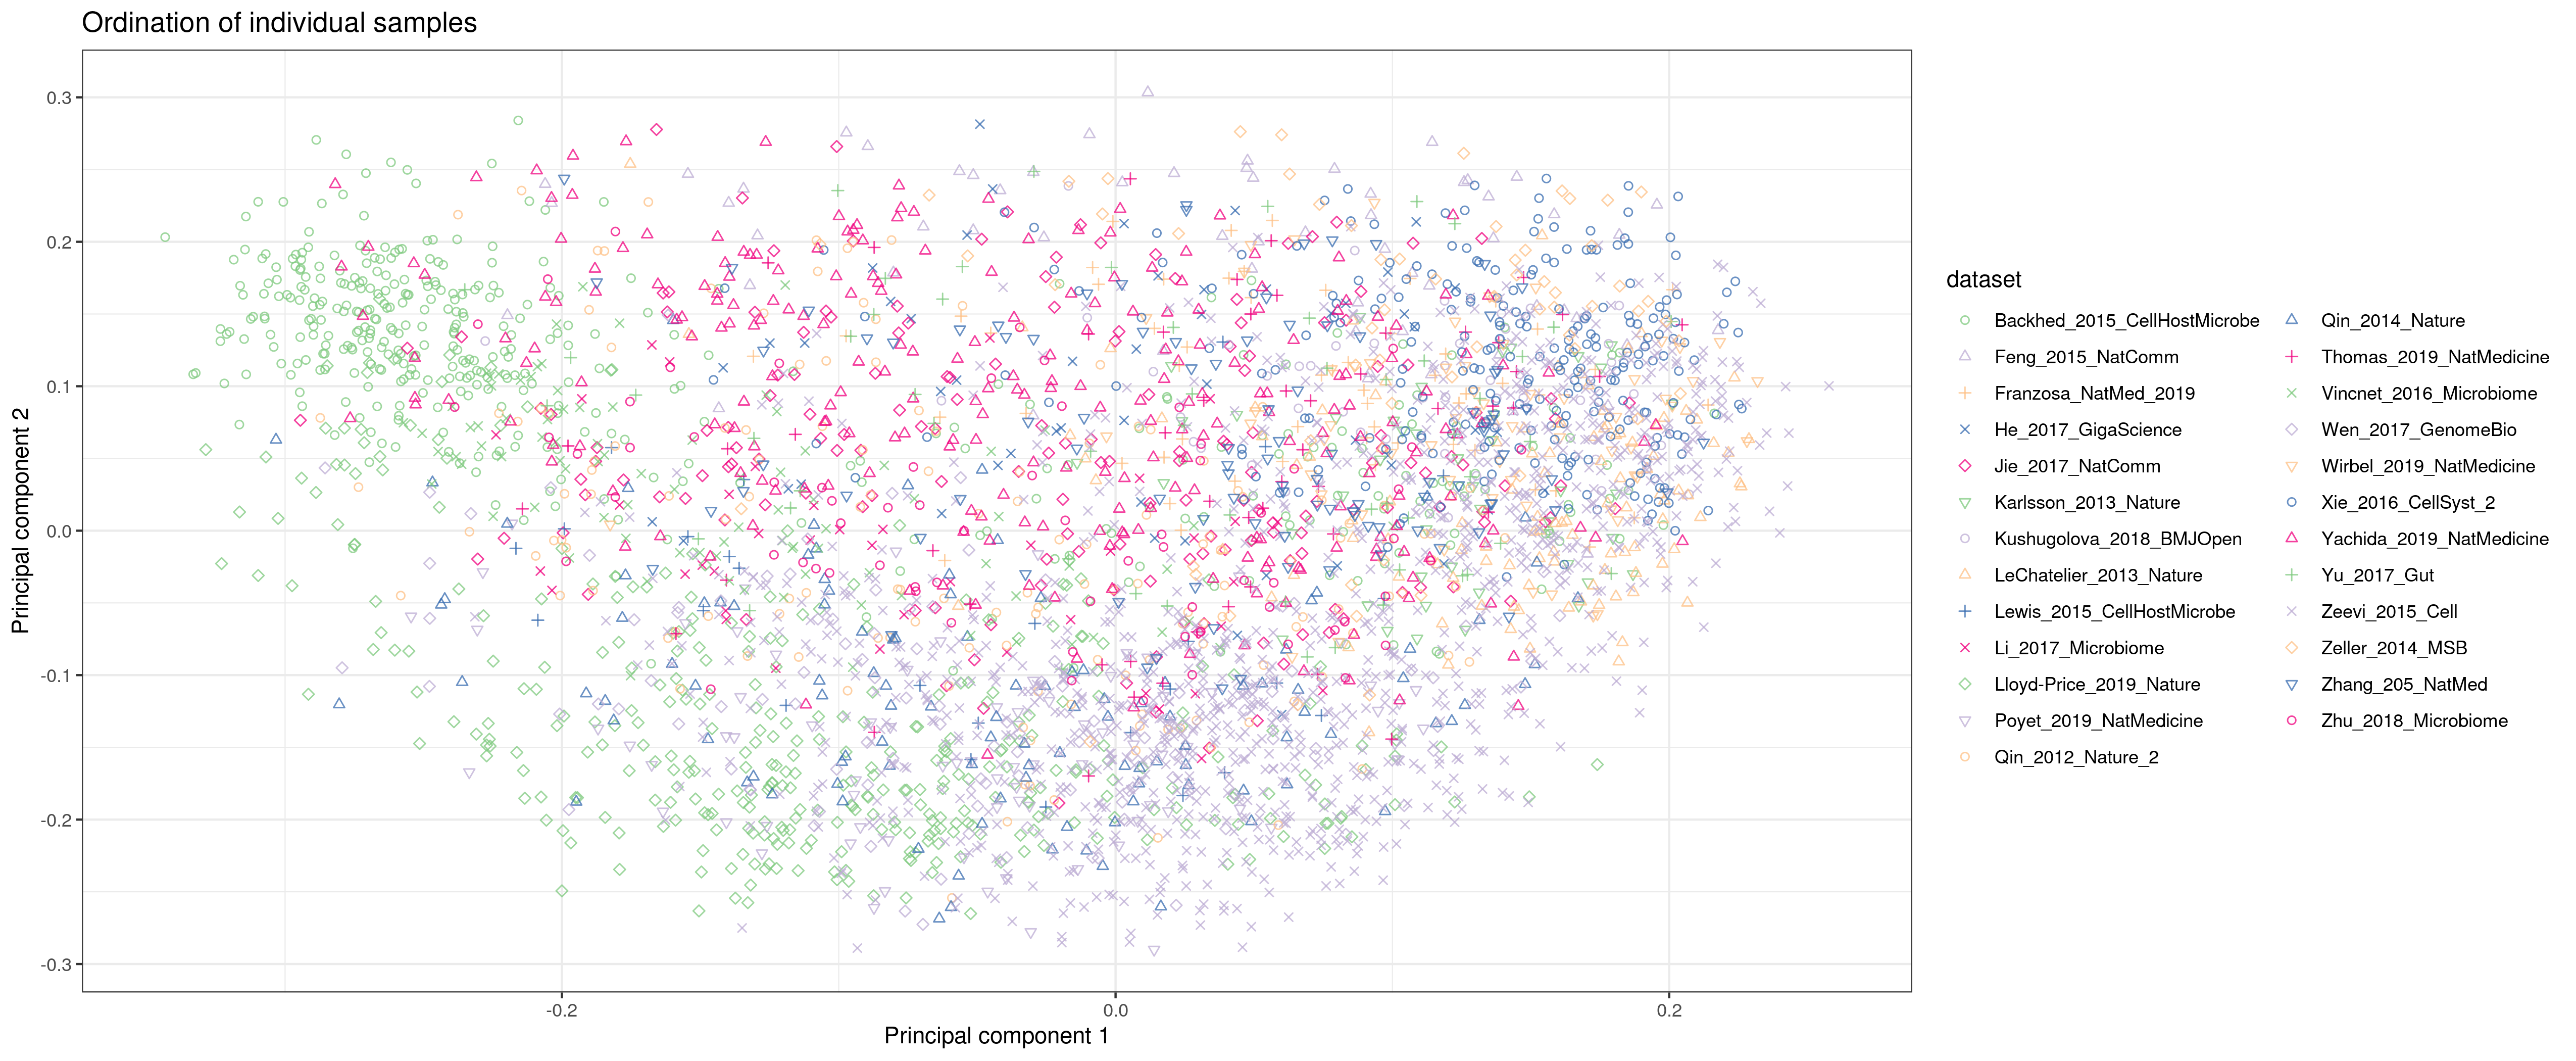

In [395]:
po

In [380]:
dataMetaAdaptedTruncLongAll <- dataMetaAdaptedTruncWideAll %>%
mutate(genus = rownames(.)) %>%
left_join( read_tsv('../data/motus2.6_taxonomy_NCBI.tax') %>%
                                                    select(Genus, Phylum) %>%
                                                    distinct() %>%                                                      
                                                    rename(genus = Genus, phylum = Phylum)) %>%
mutate(genus = map_chr(genus, function(x) str_split(x, " " )[[1]][2])) %>%
mutate(phylum = map_chr(phylum, function(x) str_split(x, " " )[[1]][2])) %>%                       
#mutate(genus = map_chr(genus, function(x) str_split(x, " ")[[1]][2])) %>%
pivot_longer(-c(genus, phylum)) %>%
rename(sampleID = name,
      relativeAbundance = value)
dataMetaAdaptedTruncLongAll <- dataMetaAdaptedTruncLongAll %>%
             distinct(genus, sampleID, .keep_all = T)                        

Parsed with column specification:
cols(
  mOTUs_ID = col_character(),
  Kingdom = col_character(),
  Phylum = col_character(),
  Class = col_character(),
  Order = col_character(),
  Family = col_character(),
  Genus = col_character(),
  Species = col_character(),
  profiled = col_character()
)

Joining, by = "genus"


In [381]:
dataMetaAdaptedTruncLongAll$genus <- factor(dataMetaAdaptedTruncLongAll$genus, levels = dataMetaAdaptedTruncLongAll %>% group_by(genus) %>% summarize(m = quantile(relativeAbundance, 0.76)) %>% arrange(desc(m)) %>% pull(genus))

`summarise()` ungrouping output (override with `.groups` argument)


In [382]:
prevs <- dataMetaAdaptedTruncLongAll %>%
group_by(genus) %>%
summarize(Prevalence = mean(relativeAbundance > 0))
prevs$genus <- factor(prevs$genus, levels = levels(dataMetaAdaptedTruncLongAll$genus))

`summarise()` ungrouping output (override with `.groups` argument)


In [383]:
# prevs <- prevs %>%
# filter(Prevalence > 0.1)
# dataMetaAdaptedTruncLongAll <- dataMetaAdaptedTruncLongAll %>% filter(genus %in% prevs$genus)
toKeep <- levels(dataMetaAdaptedTruncLongAll$genus)[1:30]
dataMetaAdaptedTruncLongAll <- dataMetaAdaptedTruncLongAll %>% filter(genus %in% toKeep)
prevs <- prevs %>% filter(genus %in% toKeep)
dataMetaAdaptedTruncLongAll$genus <- factor(dataMetaAdaptedTruncLongAll$genus, levels = rev(levels(dataMetaAdaptedTruncLongAll$genus)))
prevs$genus <- factor(prevs$genus, levels = rev(levels(prevs$genus)))

In [384]:
#dataMetaAdaptedTruncLongAll$genus <- factor(dataMetaAdaptedTruncLongAll$genus, levels = dataMetaAdaptedTruncLongAll %>% group_by(genus) %>% summarize(m = median(relativeAbundance)) %>% arrange(m) %>% pull(genus))
#prevs <- dataMetaAdaptedTruncLongAll %>%
#group_by(genus) %>%
#summarize(Prevalence = mean(relativeAbundance > 0))
#prevs$genus <- factor(prevs$genus, levels = levels(dataMetaAdaptedTruncLongAll$genus))

In [386]:
#options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 300)
p <- ggplot() +
#geom_hline(yintercept = 1E-5, alpha = 0.2) +
geom_hline(yintercept = 1E-4, alpha = 0.2) +
geom_hline(yintercept = 1E-3, alpha = 0.2) +
geom_hline(yintercept = 1E-2, alpha = 0.2) +
geom_hline(yintercept = 1E-1, alpha = 0.2) +
geom_boxplot(data = dataMetaAdaptedTruncLongAll, aes(x = genus, y = relativeAbundance + 1E-5, fill = phylum), outlier.color = NA) +
geom_point(data = dataMetaAdaptedTruncLongAll %>%
           filter(sampleID == (pcoa_o %>% filter(shape == 5) %>% pull(Sample_ID))), aes(x = genus, y = relativeAbundance + 1E-5), color = 'red', shape = 5) +
geom_point(data = dataMetaAdaptedTruncLongAll %>%
           filter(sampleID == (pcoa_o %>% filter(shape == 1) %>% pull(Sample_ID))), aes(x = genus, y = relativeAbundance + 1E-5), color = 'red', shape = 1) +
scale_fill_manual(values = c("#b3e2cd", "#fdcdac", "#cbd5e8", "#f4cae4", "#e6f5c9", "#fff2ae")) +
#scale_y_continuous(breaks = ) +
#ylim(breaks = c(0.0001, 0.01)) +
scale_y_log10(breaks = c(1E-5, 1E-4, 1E-3, 1E-2, 1E-1), labels = c("0.001%", "0.01%", "0.1%", "1%", "10%")) + 
theme_classic() +
#theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
theme(legend.position = 'left') + 
coord_flip() + 
ylab("Relative abundance") +
xlab("") +
NULL

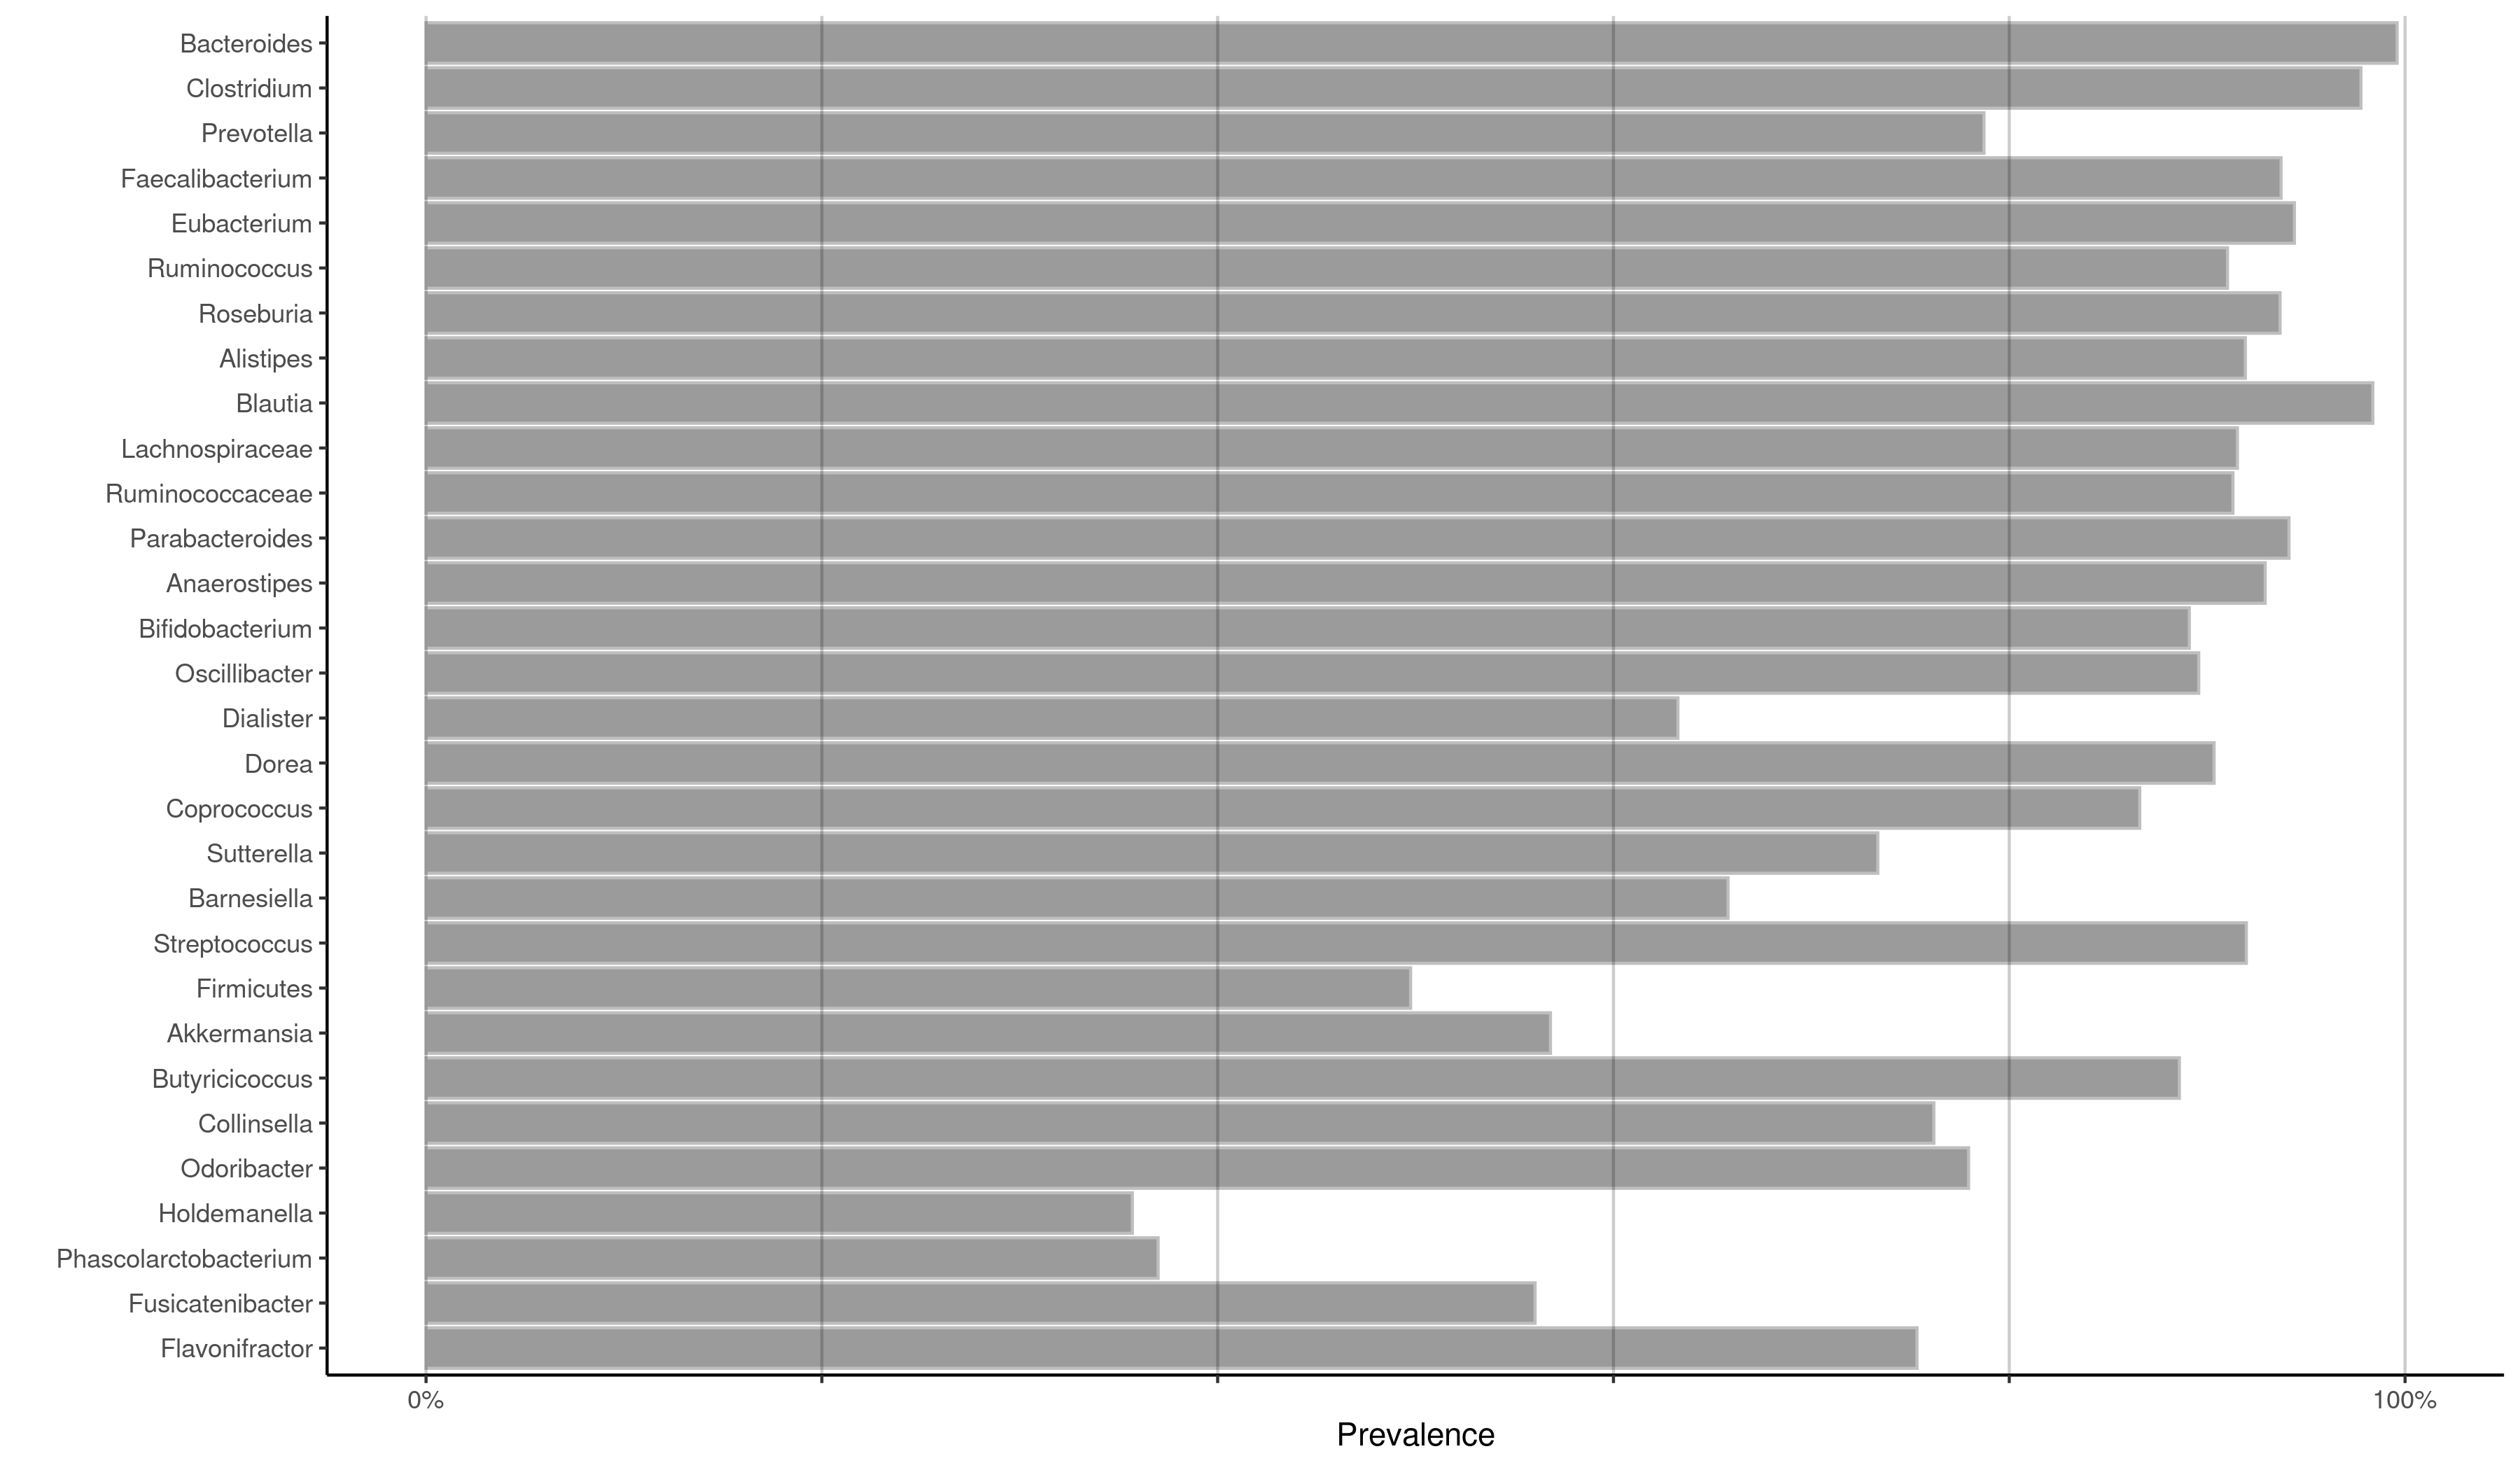

In [377]:
pp <- ggplot() +
geom_bar(data = prevs, aes(x = genus, y = Prevalence), alpha = 0.6, color = 'grey', stat = 'identity')  +
theme_classic() +
geom_hline(yintercept = 0, alpha = 0.2) +
geom_hline(yintercept = 0.2, alpha = 0.2) +
geom_hline(yintercept = 0.4, alpha = 0.2) +
geom_hline(yintercept = 0.6, alpha = 0.2) +
geom_hline(yintercept = 0.8, alpha = 0.2) +
geom_hline(yintercept = 1, alpha = 0.2) +
coord_flip() +
scale_y_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1), labels = c("0%", "", "", "", "", "100%")) +
xlab("") +
NULL
print(pp)


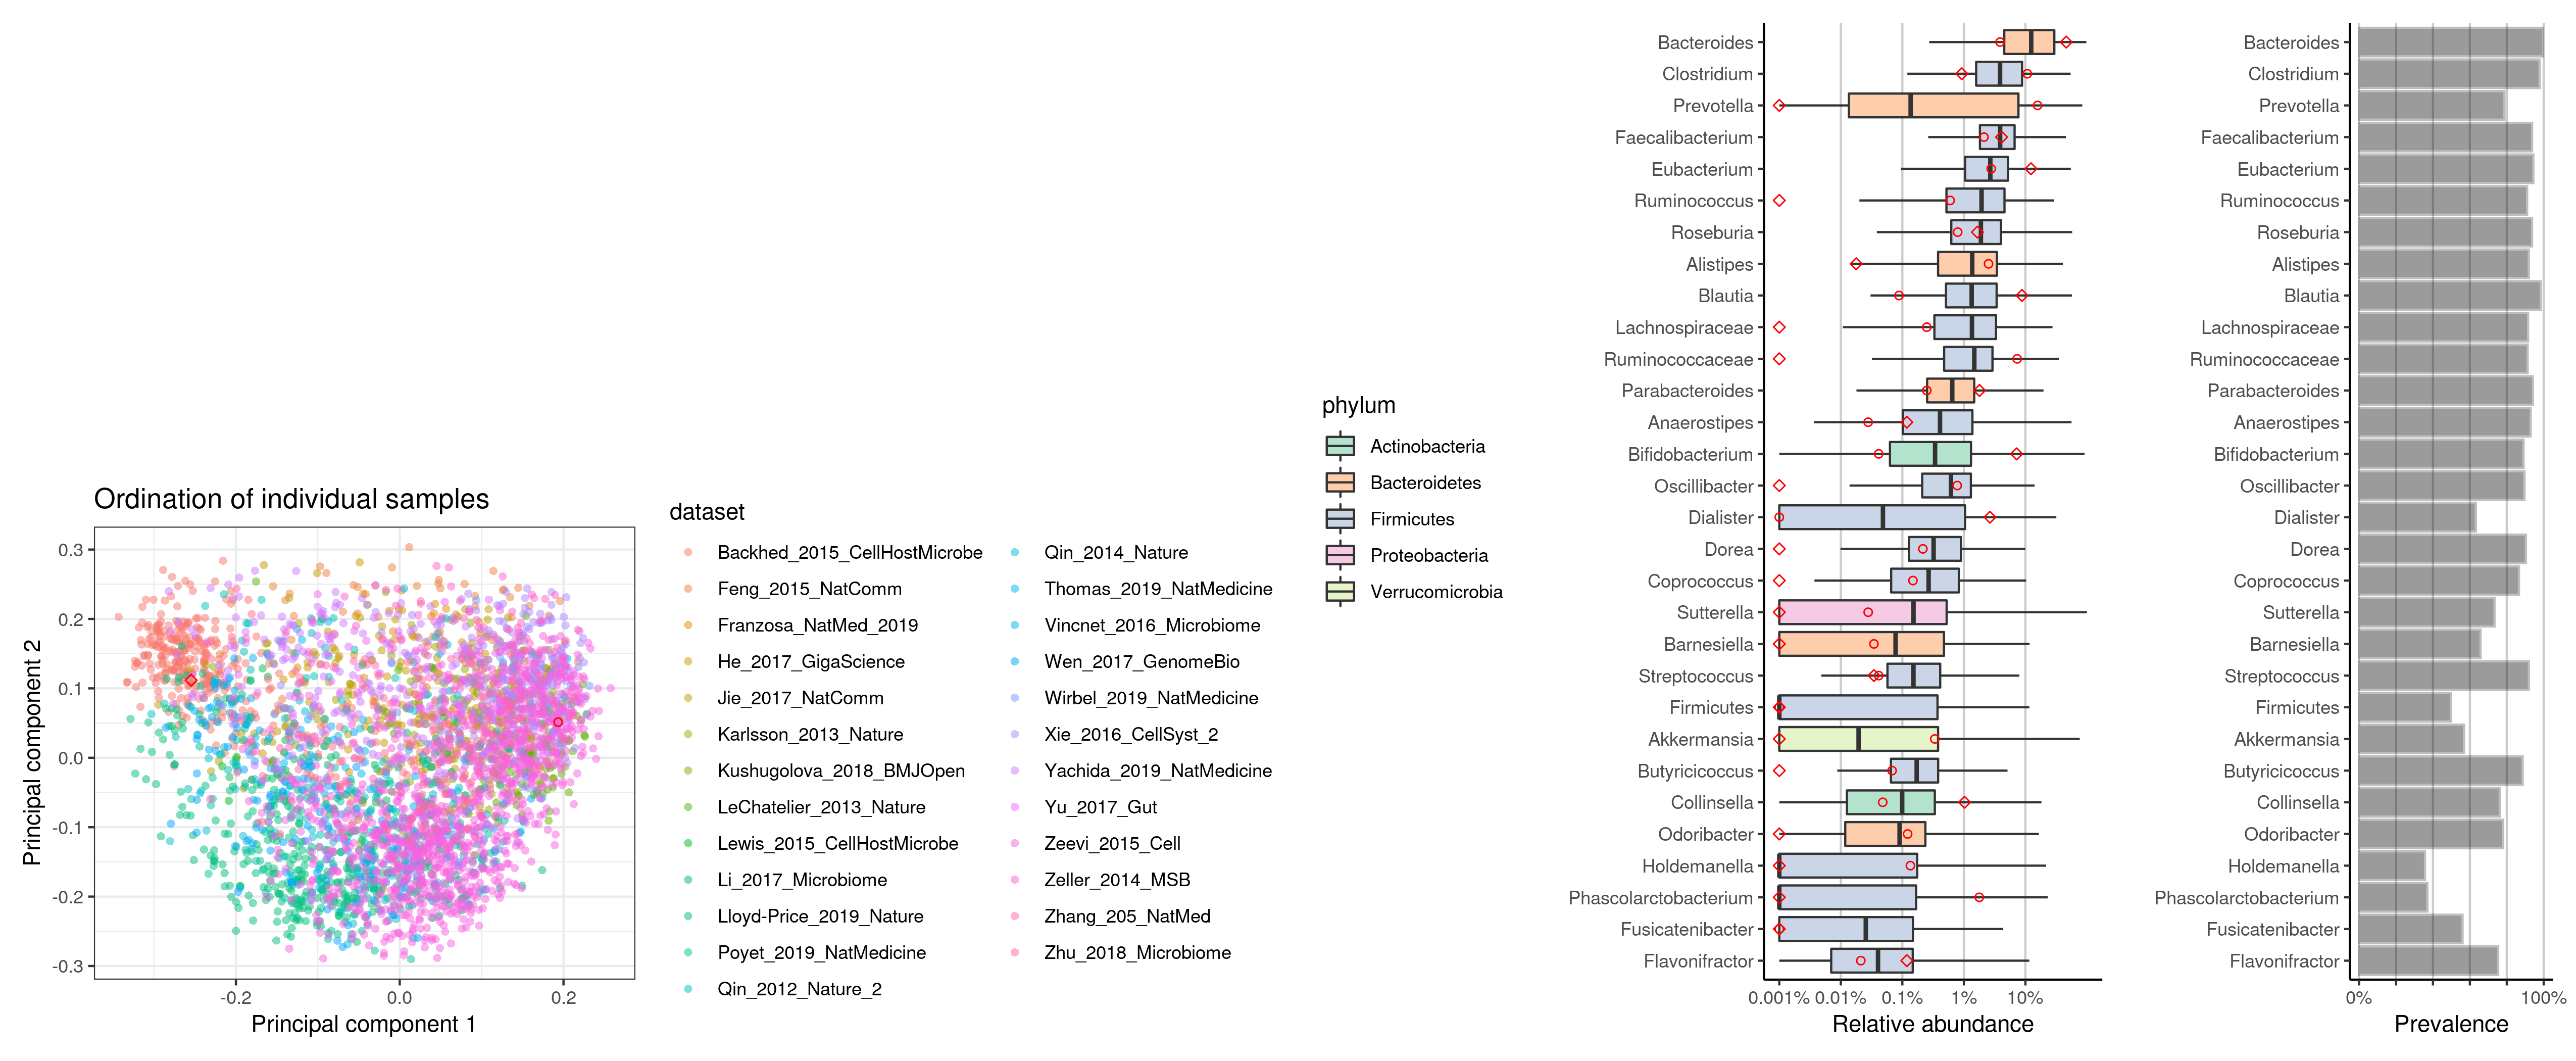

In [392]:
library(patchwork)
options(repr.plot.width = 17, repr.plot.height = 7, repr.plot.res = 300)
#p, pp, po
#po + p + pp + plot_layout(widths = c(0.4, 0.4, 0.2), heights = c(0.6, 1, 1))
layout <- "
########BBBBBDDD
########BBBBBDDD
AAAAAAAABBBBBDDD
AAAAAAAABBBBBDDD
"
po + p + pp + plot_layout(design = layout)

In [396]:
metaDataWGS %>% pull(dataset) %>% head(1)

[1] "Backhed_2015_CellHostMicrobe"